# Exploratory data analysis

#### Importing packages 

In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

#### Loading the pickled turnstiles dataframe

In [2]:
turnstiles_df = pd.read_pickle('turnstiles_df.pickle')
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES_EXITS
209469,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,1900-01-01 21:00:00,2021-03-26 21:00:00,6098
209468,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,1900-01-01 17:00:00,2021-03-26 17:00:00,6098
209467,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,1900-01-01 13:00:00,2021-03-26 13:00:00,6098
209466,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,1900-01-01 09:00:00,2021-03-26 09:00:00,6098
209465,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-03-26,1900-01-01 05:00:00,2021-03-26 05:00:00,6098


## 1. Finding the station with the highest entries/exits foot traffic

### 1.1 Calculating daily entries/exits traffic

Finding the maximum (end of day) entries/exits traffic for each turnstile  
(the maximum entries and exits would occur at the last reading of the day. Since rows are listed in descending order of time, we can grab the last reading of the day (located at the top of the group) using the .first() DataFrame method)

In [3]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES_EXITS.first())
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_EXITS
0,A002,R051,02-00-00,59 ST,2020-12-26,10066556
1,A002,R051,02-00-00,59 ST,2020-12-27,10066986
2,A002,R051,02-00-00,59 ST,2020-12-28,10067929
3,A002,R051,02-00-00,59 ST,2020-12-29,10068802
4,A002,R051,02-00-00,59 ST,2020-12-30,10069652


Calculating daily turnstile entries/exits traffic

In [4]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES_EXITS"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES_EXITS"]]
                                                       .shift(1))
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_EXITS,PREV_DATE,PREV_ENTRIES_EXITS
0,A002,R051,02-00-00,59 ST,2020-12-26,10066556,NaT,NaN
1,A002,R051,02-00-00,59 ST,2020-12-27,10066986,2020-12-26,10066556.0
2,A002,R051,02-00-00,59 ST,2020-12-28,10067929,2020-12-27,10066986.0
3,A002,R051,02-00-00,59 ST,2020-12-29,10068802,2020-12-28,10067929.0
4,A002,R051,02-00-00,59 ST,2020-12-30,10069652,2020-12-29,10068802.0


Dropping the rows for the earliest date in the dataframe

In [5]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_EXITS,PREV_DATE,PREV_ENTRIES_EXITS
1,A002,R051,02-00-00,59 ST,2020-12-27,10066986,2020-12-26,10066556.0
2,A002,R051,02-00-00,59 ST,2020-12-28,10067929,2020-12-27,10066986.0
3,A002,R051,02-00-00,59 ST,2020-12-29,10068802,2020-12-28,10067929.0
4,A002,R051,02-00-00,59 ST,2020-12-30,10069652,2020-12-29,10068802.0
5,A002,R051,02-00-00,59 ST,2020-12-31,10070231,2020-12-30,10069652.0


Checking to see if daily entries/exits are positive and not too large

In [6]:
(turnstiles_daily["ENTRIES_EXITS"] - turnstiles_daily["PREV_ENTRIES_EXITS"]).describe()

count    4.488750e+05
mean    -2.130679e+03
std      8.983102e+06
min     -2.731588e+09
25%      1.310000e+02
50%      3.950000e+02
75%      7.800000e+02
max      3.539499e+09
dtype: float64

Checking to see how many rows have entries/exits smaller than their previous entries/exits

In [7]:
turnstiles_daily[turnstiles_daily["ENTRIES_EXITS"] < turnstiles_daily["PREV_ENTRIES_EXITS"]].shape

(4110, 8)

#### Note:
- We have negative values for both entries and exits 
- Some values are way too big for both entries and exits

#### Creating a daily entries/exits traffic column taking into consideration reverse entries/exits and entries/exits that seem too big

(Setting max counter as 1,000,000)

(OR? Setting max counter as 200,000 because there are 84,600 seconds in a day and it is near impossible that people can exit and enter a turnstile more than double that number of time in a day)

In [8]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES_EXITS"] - row["PREV_ENTRIES_EXITS"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES_EXITS"]} <-- {row["PREV_ENTRIES_EXITS"]}')
        counter = min(row["ENTRIES_EXITS"], row["PREV_ENTRIES_EXITS"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily["DAILY_ENTRIES_EXITS"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

turnstiles_daily.head()

entries: 326 <-- 15510851.0
entries: 98330 <-- 35933562.0
entries: 301 <-- 41538834.0
entries: 252 <-- 6821752.0
entries: 393220 <-- 202882759.0
entries: 2685 <-- 1648400.0
entries: 243 <-- 3889973.0
entries: 89 <-- 5153759.0
entries: 197 <-- 2024782.0
entries: 8273099 <-- 5447183.0
entries: 1638448 <-- 8273831.0
entries: 136 <-- 1641837.0
entries: 766 <-- 1288384.0
entries: 327907 <-- 3435059.0
entries: 16860616 <-- 180544.0
entries: 721483908 <-- 2840043.0
entries: 262388 <-- 3737209.0
entries: 108 <-- 2669927.0
entries: 16712067 <-- 8670197.0
entries: 279 <-- 16712991.0
entries: 673 <-- 4184933.0
entries: 241 <-- 202655055.0
entries: 198 <-- 17997783.0
entries: 3379 <-- 29079019.0
entries: 112 <-- 14331544.0
entries: 258 <-- 1052823.0
entries: 2293806 <-- 10907224.0
entries: 43 <-- 3368330.0
entries: 1377460 <-- 2549981.0
entries: 1261 <-- 1379132.0
entries: 517 <-- 2731588401.0
entries: 57 <-- 1306536.0
entries: 2 <-- 83886189.0
entries: 229 <-- 8272936.0
entries: 1638695 <-- 14401

,C/A,UNIT,SCP,STATION,DATE,ENTRIES_EXITS,PREV_DATE,PREV_ENTRIES_EXITS,DAILY_ENTRIES_EXITS
1,A002,R051,02-00-00,59 ST,2020-12-27,10066986,2020-12-26,10066556.0,430.0
2,A002,R051,02-00-00,59 ST,2020-12-28,10067929,2020-12-27,10066986.0,943.0
3,A002,R051,02-00-00,59 ST,2020-12-29,10068802,2020-12-28,10067929.0,873.0
4,A002,R051,02-00-00,59 ST,2020-12-30,10069652,2020-12-29,10068802.0,850.0
5,A002,R051,02-00-00,59 ST,2020-12-31,10070231,2020-12-30,10069652.0,579.0


Checking to see if the daily entries/exits traffic makes sense

In [9]:
turnstiles_daily.DAILY_ENTRIES_EXITS.describe()

count    448875.000000
mean        615.024557
std        5265.107219
min           0.000000
25%         138.000000
50%         400.000000
75%         785.000000
max      891655.000000
Name: DAILY_ENTRIES_EXITS, dtype: float64

#### Calculating daily entries/exits traffic for each station

In [10]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_ENTRIES_EXITS']].sum().reset_index().copy()
station_daily.head()

,STATION,DATE,DAILY_ENTRIES_EXITS
0,1 AV,2020-12-27,6748.0
1,1 AV,2020-12-28,12405.0
2,1 AV,2020-12-29,13486.0
3,1 AV,2020-12-30,13509.0
4,1 AV,2020-12-31,11429.0


In [12]:
station_daily.sort_values('DAILY_ENTRIES_EXITS', ascending=False).head()

,STATION,DATE,DAILY_ENTRIES_EXITS
31709,TIMES SQ-42 ST,2021-02-05,1113904.0
5393,34 ST-HERALD SQ,2021-03-25,908551.0
8580,7 AV,2021-01-31,898062.0
23084,JFK JAMAICA CT1,2021-02-17,834591.0
21048,GRD CNTRL-42 ST,2021-03-23,778514.0


## 1.1 Ans: Calculating total entries/exits traffic for each station to find the station with the highest traffic

In [13]:
station_totals = station_daily.groupby('STATION')['DAILY_ENTRIES_EXITS'].sum() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES_EXITS', ascending=False).copy()

station_totals.head()

,STATION,DAILY_ENTRIES_EXITS
61,34 ST-PENN STA,6218194.0
59,34 ST-HERALD SQ,5375856.0
233,GRD CNTRL-42 ST,4646933.0
352,TIMES SQ-42 ST,4613925.0
9,125 ST,4442009.0


## 1.2 Ans: Calculating average entries/exits traffic per day for each station to find the stations with the highest traffic

In [15]:
station_average = station_daily.groupby('STATION')['DAILY_ENTRIES_EXITS'].mean() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES_EXITS', ascending=False).copy()

station_average_highest = station_average.head(10).copy()
station_average_highest

,STATION,DAILY_ENTRIES_EXITS
61,34 ST-PENN STA,69091.044444
59,34 ST-HERALD SQ,59731.733333
233,GRD CNTRL-42 ST,51632.588889
352,TIMES SQ-42 ST,51265.833333
9,125 ST,49355.655556
110,86 ST,48684.777778
68,42 ST-PORT AUTH,42630.077778
14,14 ST-UNION SQ,42573.811111
86,59 ST COLUMBUS,40999.722222
85,59 ST,40159.788889


## 1.2 Ans Plot
NOTE: Visuals will be in a different notebook eventually

#### Importing packages

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']  # or retina
%matplotlib inline

sns.set(context='notebook', 
    style='whitegrid', 
    font_scale=1.1)

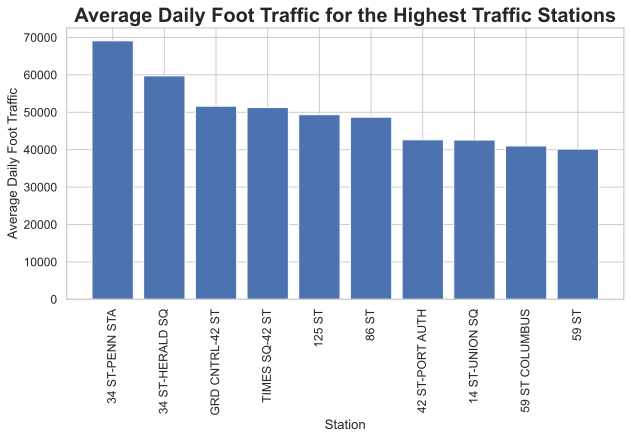

In [17]:
plt.figure(figsize=(10,5));
plt.bar(station_average_highest["STATION"], station_average_highest["DAILY_ENTRIES_EXITS"])
plt.xlabel("Station")
plt.ylabel("Average Daily Foot Traffic")
ticks_y = np.linspace(0, 70000, 8)
plt.yticks(ticks_y)
#plt.xticks([], [])
#plt.axis([0, 0, 0, 70000])
plt.xticks(rotation=90)
plt.title("Average Daily Foot Traffic for the Highest Traffic Stations", weight='bold', fontsize=20);

## 1.2.2 (Still working on this) Comparing the Highest Traffic Stations in 2019 and 2021

Loading pickled Jan-March 2019 highest traffic stations dataframe 

In [36]:
station_average_highest2 = pd.read_pickle('station_average_highest2.pickle')

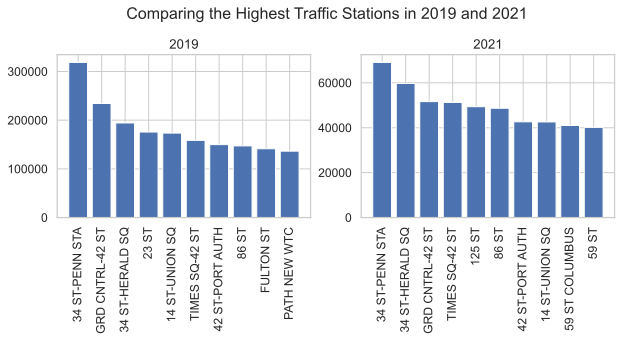

In [41]:
plt.figure(figsize=[10,3])

plt.suptitle('Comparing the Highest Traffic Stations in 2019 and 2021',fontsize = 16, y=1.1)

plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
plt.bar(station_average_highest2["STATION"], station_average_highest2["DAILY_ENTRIES_EXITS"])
plt.title('2019')
plt.xticks(rotation=90)

plt.subplot(1,2,2)
plt.bar(station_average_highest["STATION"], station_average_highest["DAILY_ENTRIES_EXITS"])
plt.title('2021')
plt.xticks(rotation=90);

 ## 1.3 (Still working on this) Ranking Stations by Traffic

In [18]:
station_average.describe()

,DAILY_ENTRIES_EXITS
count,378.000000
mean,8116.206598
std,9583.192128
min,132.100000
25%,2683.050000
50%,5064.861111
75%,9335.516667
max,69091.044444


In [19]:
station_average["TRAFFIC_LEVEL"] = pd.qcut(station_average["DAILY_ENTRIES_EXITS"], q=3, labels=["Low", "Medium", "High"])
station_average.sample(5)

,STATION,DAILY_ENTRIES_EXITS,TRAFFIC_LEVEL
218,FORDHAM RD,15765.066667,High
122,ASTOR PL,6445.122222,Medium
216,FLUSHING AV,8255.977778,High
300,NEWARK HM HE,5135.666667,Medium
217,FLUSHING-MAIN,36690.333333,High


 ## 2. Finding the days of the week with the highest entries/exits foot traffic*
 * for the stations with the highest traffic

 #### Creating a new dataframe with only the highest traffic stations

In [20]:
highest_stations = station_daily.loc[(station_daily["STATION"] == "34 ST-PENN STA")
                                     | (station_daily["STATION"] == "34 ST-HERALD SQ") 
                                     | (station_daily["STATION"] == "GRD CNTRL-42 ST") 
                                     | (station_daily["STATION"] == "TIMES SQ-42 ST")                                  
                                     | (station_daily["STATION"] == "125 ST") 
                                     | (station_daily["STATION"] == "86 ST")
                                     | (station_daily["STATION"] == "14 ST-UNION SQ") 
                                     | (station_daily["STATION"] == "42 ST-PORT AUTH") 
                                     | (station_daily["STATION"] == "59 ST COLUMBUS") 
                                     | (station_daily["STATION"] == "59 ST")].copy()
highest_stations.head()

,STATION,DATE,DAILY_ENTRIES_EXITS
808,125 ST,2020-12-27,28787.0
809,125 ST,2020-12-28,48154.0
810,125 ST,2020-12-29,50170.0
811,125 ST,2020-12-30,51662.0
812,125 ST,2020-12-31,46992.0


In [21]:
highest_stations['DAY_OF_WEEK_NUM'] = pd.to_datetime(station_daily['DATE']).dt.dayofweek
highest_stations.head()

,STATION,DATE,DAILY_ENTRIES_EXITS,DAY_OF_WEEK_NUM
808,125 ST,2020-12-27,28787.0,6
809,125 ST,2020-12-28,48154.0,0
810,125 ST,2020-12-29,50170.0,1
811,125 ST,2020-12-30,51662.0,2
812,125 ST,2020-12-31,46992.0,3


In [22]:
highest_stations.sort_values('DAILY_ENTRIES_EXITS', ascending=False)

,STATION,DATE,DAILY_ENTRIES_EXITS,DAY_OF_WEEK_NUM
31709,TIMES SQ-42 ST,2021-02-05,1113904.0,4
5393,34 ST-HERALD SQ,2021-03-25,908551.0,3
21048,GRD CNTRL-42 ST,2021-03-23,778514.0,1
31738,TIMES SQ-42 ST,2021-03-06,701727.0,5
7820,59 ST COLUMBUS,2021-03-22,674316.0,0
...,...,...,...,...
7771,59 ST COLUMBUS,2021-02-01,13078.0,0
7742,59 ST COLUMBUS,2021-01-03,13007.0,6
31711,TIMES SQ-42 ST,2021-02-07,12465.0,6
6151,42 ST-PORT AUTH,2021-02-01,12155.0,0


### 2. Ans:

In [23]:
day_of_week_avg = highest_stations.groupby('DAY_OF_WEEK_NUM')['DAILY_ENTRIES_EXITS'].mean() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES_EXITS', ascending=False)

day_of_week_avg.head(10)

,DAY_OF_WEEK_NUM,DAILY_ENTRIES_EXITS
4,4,66804.000000
3,3,56126.092308
1,1,55330.276923
0,0,52198.723077
2,2,50804.107692
5,5,39208.375000
6,6,26015.630769


### 2. Plot 

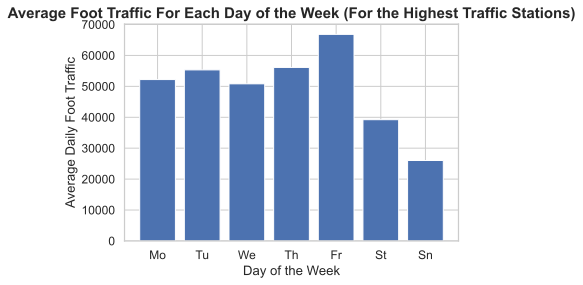

In [24]:
plt.bar(day_of_week_avg['DAY_OF_WEEK_NUM'], day_of_week_avg['DAILY_ENTRIES_EXITS'])
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Foot Traffic')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Average Foot Traffic For Each Day of the Week (For the Highest Traffic Stations)', weight='bold', fontsize=15);

### 2.2 (Still working on this) Plot comparing highest traffic days of the week in 2019 and 2020 

In [45]:
day_of_week_avg2 = pd.read_pickle('day_of_week_avg2.pickle')

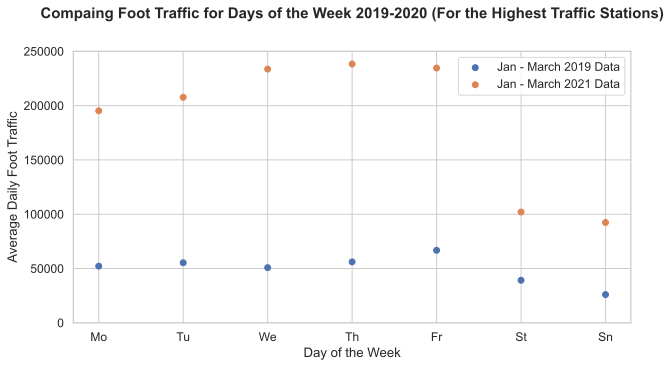

In [62]:
plt.figure(figsize=(10,5))

plt.scatter(day_of_week_avg['DAY_OF_WEEK_NUM'], day_of_week_avg['DAILY_ENTRIES_EXITS'])
plt.scatter(day_of_week_avg2['DAY_OF_WEEK_NUM'], day_of_week_avg2['DAILY_ENTRIES_EXITS'])
plt.xlabel('Day of the Week')
plt.ylabel('Average Daily Foot Traffic')
plt.title('Compaing Foot Traffic for Days of the Week 2019-2020 (For the Highest Traffic Stations)', weight='bold', fontsize=15, y=1.1);

#plt.bar(day_of_week_avg['DAY_OF_WEEK_NUM'], day_of_week_avg['DAILY_ENTRIES_EXITS'], width=0.25)
#plt.bar(day_of_week_avg2['DAY_OF_WEEK_NUM'], day_of_week_avg2['DAILY_ENTRIES_EXITS'], width=0.25)
#ax.set_ylabel('Daily Traffic')
#ax.set_title('Days of the Week')

plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.yticks(np.linspace(0,250000, 6), ['0','50000', '100000','150000','200000','250000'])
           
plt.legend(['Jan - March 2019 Data','Jan - March 2021 Data'],loc = 0);


### 2.2 Plots Continued

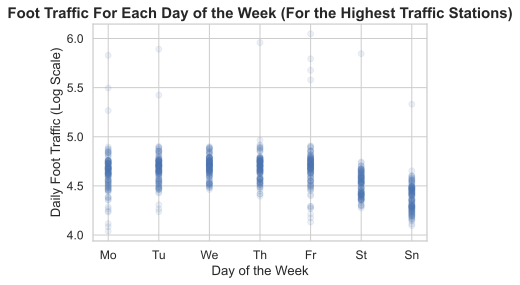

In [35]:
new_x = highest_stations['DAY_OF_WEEK_NUM']
new_y = highest_stations['DAILY_ENTRIES_EXITS']
plt.xlabel('Day of the Week')
plt.ylabel('Daily Foot Traffic (Log Scale)')
plt.title('Foot Traffic For Each Day of the Week (For the Highest Traffic Stations)', weight='bold', fontsize=15);
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.scatter(new_x,np.log10(new_y), alpha = 0.1);

### 2.2.2 (Still working on this) Plot comparing highest traffic days of the week in 2019 and 2020

In [64]:
highest_stations2 = pd.read_pickle('highest_stations2.pickle')

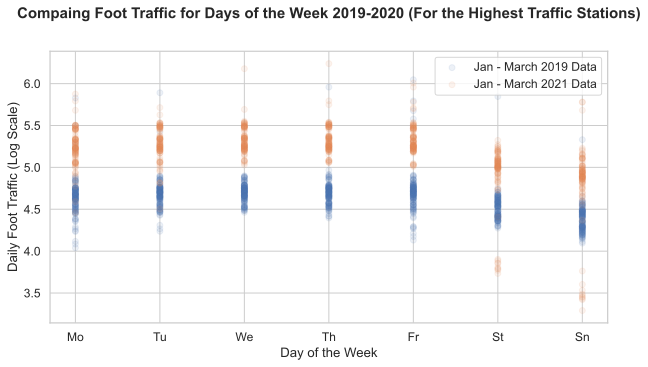

In [65]:
plt.figure(figsize=(10,5))

plt.scatter(highest_stations['DAY_OF_WEEK_NUM'],np.log10(highest_stations['DAILY_ENTRIES_EXITS']), alpha = 0.1)
plt.scatter(highest_stations2['DAY_OF_WEEK_NUM'],np.log10(highest_stations2['DAILY_ENTRIES_EXITS']), alpha = 0.1)
plt.xlabel('Day of the Week')
plt.ylabel('Daily Foot Traffic (Log Scale)')
plt.title('Compaing Foot Traffic for Days of the Week 2019-2020 (For the Highest Traffic Stations)', weight='bold', fontsize=15, y=1.1);

plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
#plt.yticks(np.linspace(0,250000, 6), ['0','50000', '100000','150000','200000','250000'])
           
plt.legend(['Jan - March 2019 Data','Jan - March 2021 Data'],loc = 0);

## 3. Finding the hours of the day with the highest entries/exits foot traffic 

#### Same steps as above for finding "turnstiles_daily"

In [28]:
turnstiles_timeblock = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "TIME"],as_index=False)
                        .ENTRIES_EXITS.first())
turnstiles_timeblock.head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES_EXITS
0,A002,R051,02-00-00,59 ST,1900-01-01 00:00:00,10126542
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,10117474
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,10126552
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,10117490
4,A002,R051,02-00-00,59 ST,1900-01-01 08:00:00,10126621


In [29]:
turnstiles_timeblock[["PREV_TIME", "PREV_ENTRIES_EXITS"]] = (turnstiles_timeblock
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])[["TIME", "ENTRIES_EXITS"]]
                                                       .shift(1))
turnstiles_timeblock.head(15)

,C/A,UNIT,SCP,STATION,TIME,ENTRIES_EXITS,PREV_TIME,PREV_ENTRIES_EXITS
0,A002,R051,02-00-00,59 ST,1900-01-01 00:00:00,10126542,NaT,NaN
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,10117474,1900-01-01 00:00:00,10126542.0
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,10126552,1900-01-01 03:00:00,10117474.0
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,10117490,1900-01-01 04:00:00,10126552.0
4,A002,R051,02-00-00,59 ST,1900-01-01 08:00:00,10126621,1900-01-01 07:00:00,10117490.0
5,A002,R051,02-00-00,59 ST,1900-01-01 11:00:00,10117592,1900-01-01 08:00:00,10126621.0
6,A002,R051,02-00-00,59 ST,1900-01-01 12:00:00,10126782,1900-01-01 11:00:00,10117592.0
7,A002,R051,02-00-00,59 ST,1900-01-01 12:16:53,10067244,1900-01-01 12:00:00,10126782.0
8,A002,R051,02-00-00,59 ST,1900-01-01 15:00:00,10117772,1900-01-01 12:16:53,10067244.0
9,A002,R051,02-00-00,59 ST,1900-01-01 16:00:00,10126975,1900-01-01 15:00:00,10117772.0


In [30]:
turnstiles_timeblock.dropna(subset=["PREV_TIME"], axis=0, inplace=True)

In [31]:
def get_timeblock_counts(row, max_counter):
    counter = row["ENTRIES_EXITS"] - row["PREV_ENTRIES_EXITS"]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        print(f'entries: {row["ENTRIES_EXITS"]} <-- {row["PREV_ENTRIES_EXITS"]}')
        counter = min(row["ENTRIES_EXITS"], row["PREV_ENTRIES_EXITS"])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_timeblock["TIMEBLOCK_ENTRIES_EXITS"] = turnstiles_timeblock.apply(get_timeblock_counts, axis=1, max_counter=100000)

turnstiles_timeblock.head()

entries: 15503699 <-- 3691.0
entries: 3697 <-- 15503699.0
entries: 15503725 <-- 3697.0
entries: 3849 <-- 15503725.0
entries: 15503864 <-- 3849.0
entries: 4109 <-- 15503864.0
entries: 15442056 <-- 4109.0
entries: 4319 <-- 15503925.0
entries: 15504123 <-- 4319.0
entries: 4591 <-- 15504123.0
entries: 15504235 <-- 4591.0
entries: 8078493 <-- 7975875.0
entries: 7975901 <-- 8078493.0
entries: 4409103 <-- 4521351.0
entries: 4355553 <-- 4494320.0
entries: 4521776 <-- 4355578.0
entries: 4355616 <-- 4521776.0
entries: 4494820 <-- 4355616.0
entries: 20145527 <-- 20030912.0
entries: 1220194 <-- 1115542.0
entries: 202877770 <-- 404793.0
entries: 402715 <-- 202877770.0
entries: 2701 <-- 1645623.0
entries: 1645414 <-- 2701.0
entries: 2702 <-- 1645414.0
entries: 1636156 <-- 2702.0
entries: 2746 <-- 1637607.0
entries: 1637901 <-- 2746.0
entries: 2787 <-- 1645474.0
entries: 1645538 <-- 2787.0
entries: 2855 <-- 1645538.0
entries: 1645598 <-- 2855.0
entries: 2952 <-- 1645598.0
entries: 3889233 <-- 17333.0

entries: 3692788 <-- 3819511.0
entries: 3796786 <-- 3692799.0
entries: 10165584 <-- 10288568.0
entries: 10157895 <-- 10289200.0
entries: 10267471 <-- 10157906.0
entries: 95260946 <-- 95387455.0
entries: 95422721 <-- 95260946.0
entries: 95222523 <-- 95422721.0
entries: 95387602 <-- 95257984.0
entries: 95210235 <-- 95423679.0
entries: 95388400 <-- 95210253.0
entries: 412887 <-- 308606.0
entries: 387061 <-- 276736.0
entries: 15495073 <-- 15385443.0
entries: 15467322 <-- 15353009.0
entries: 33971770 <-- 33837605.0
entries: 33797372 <-- 33917924.0
entries: 33937498 <-- 33797372.0
entries: 354265 <-- 222394.0
entries: 181178 <-- 301799.0
entries: 320428 <-- 181178.0
entries: 5954139 <-- 6076351.0
entries: 6054222 <-- 5954139.0
entries: 4973825 <-- 5084193.0
entries: 5939814 <-- 6077618.0
entries: 6053040 <-- 5939815.0
entries: 495 <-- 262158.0
entries: 262151 <-- 495.0
entries: 9056511 <-- 8935068.0
entries: 5430339 <-- 5538183.0
entries: 5563759 <-- 5430339.0
entries: 687341596 <-- 38.0
ent

entries: 1853 <-- 399090.0
entries: 413177 <-- 1853.0
entries: 1090 <-- 405602.0
entries: 407039 <-- 1090.0
entries: 2126 <-- 399325.0
entries: 413323 <-- 2126.0
entries: 1409 <-- 404486.0
entries: 407236 <-- 1409.0
entries: 547 <-- 405297.0
entries: 406538 <-- 547.0
entries: 2397 <-- 397507.0
entries: 413501 <-- 2397.0
entries: 1632 <-- 398872.0
entries: 412878 <-- 1632.0
entries: 779 <-- 405507.0
entries: 406810 <-- 779.0
entries: 2707 <-- 397885.0
entries: 413690 <-- 2707.0
entries: 1855 <-- 399091.0
entries: 413179 <-- 1855.0
entries: 1090 <-- 405602.0
entries: 407040 <-- 1090.0
entries: 2126 <-- 399329.0
entries: 413323 <-- 2126.0
entries: 1409 <-- 404486.0
entries: 407238 <-- 1409.0
entries: 566 <-- 405301.0
entries: 406558 <-- 566.0
entries: 2417 <-- 397541.0
entries: 413511 <-- 2417.0
entries: 1650 <-- 398878.0
entries: 412904 <-- 1650.0
entries: 811 <-- 405512.0
entries: 406813 <-- 811.0
entries: 2742 <-- 397926.0
entries: 412387 <-- 2742.0
entries: 1926 <-- 399177.0
entries: 

entries: 579795 <-- 19838.0
entries: 0 <-- 590219.0
entries: 592647 <-- 9121.0
entries: 3278 <-- 588797.0
entries: 577677 <-- 3278.0
entries: 23698 <-- 577677.0
entries: 581279 <-- 23698.0
entries: 2954 <-- 590908.0
entries: 594889 <-- 2954.0
entries: 13017 <-- 594889.0
entries: 578492 <-- 13017.0
entries: 6340 <-- 587051.0
entries: 580055 <-- 20661.0
entries: 9917 <-- 593307.0
entries: 578009 <-- 9917.0
entries: 4299 <-- 589455.0
entries: 581640 <-- 24647.0
entries: 3599 <-- 591283.0
entries: 595673 <-- 3599.0
entries: 13759 <-- 595673.0
entries: 582335 <-- 13759.0
entries: 1543 <-- 587512.0
entries: 576944 <-- 1658.0
entries: 21742 <-- 576944.0
entries: 580626 <-- 21742.0
entries: 10973 <-- 593711.0
entries: 578166 <-- 10973.0
entries: 5151 <-- 585827.0
entries: 579387 <-- 19014.0
entries: 4016 <-- 589968.0
entries: 591880 <-- 8596.0
entries: 2470 <-- 588250.0
entries: 577361 <-- 2471.0
entries: 22909 <-- 577361.0
entries: 581161 <-- 22909.0
entries: 12028 <-- 594289.0
entries: 57834

entries: 144744 <-- 7485.0
entries: 6579 <-- 146483.0
entries: 148330 <-- 6579.0
entries: 3495 <-- 148330.0
entries: 143992 <-- 10556.0
entries: 12719 <-- 143992.0
entries: 145839 <-- 5656.0
entries: 2685 <-- 148043.0
entries: 149379 <-- 2685.0
entries: 7856 <-- 147543.0
entries: 145048 <-- 4921.0
entries: 110 <-- 145048.0
entries: 146779 <-- 11825.0
entries: 3826 <-- 148615.0
entries: 144324 <-- 10910.0
entries: 12916 <-- 144324.0
entries: 146156 <-- 5971.0
entries: 2976 <-- 148225.0
entries: 147861 <-- 2976.0
entries: 8245 <-- 147861.0
entries: 143497 <-- 10058.0
entries: 12178 <-- 143497.0
entries: 148893 <-- 5168.0
entries: 4219 <-- 147035.0
entries: 144567 <-- 7304.0
entries: 6296 <-- 144567.0
entries: 146371 <-- 13270.0
entries: 3264 <-- 148305.0
entries: 143750 <-- 10259.0
entries: 12534 <-- 143750.0
entries: 149179 <-- 5404.0
entries: 4609 <-- 147307.0
entries: 144791 <-- 7546.0
entries: 6638 <-- 146512.0
entries: 148355 <-- 6638.0
entries: 3560 <-- 148355.0
entries: 144085 <--

entries: 156008 <-- 10696.0
entries: 1973 <-- 156008.0
entries: 153117 <-- 1504.0
entries: 49679 <-- 153117.0
entries: 157302 <-- 11843.0
entries: 2985 <-- 157302.0
entries: 153902 <-- 1151.0
entries: 506 <-- 153902.0
entries: 152510 <-- 321.0
entries: 4249 <-- 152510.0
entries: 155135 <-- 9755.0
entries: 1503 <-- 155135.0
entries: 152841 <-- 1085.0
entries: 5713 <-- 152841.0
entries: 156447 <-- 11082.0
entries: 2146 <-- 156447.0
entries: 153206 <-- 1659.0
entries: 50074 <-- 153206.0
entries: 157701 <-- 12281.0
entries: 3387 <-- 157701.0
entries: 154237 <-- 8934.0
entries: 885 <-- 154237.0
entries: 152579 <-- 600.0
entries: 4678 <-- 152579.0
entries: 155399 <-- 10101.0
entries: 1694 <-- 155399.0
entries: 152948 <-- 1222.0
entries: 5964 <-- 152948.0
entries: 156585 <-- 11256.0
entries: 2247 <-- 156585.0
entries: 153241 <-- 1751.0
entries: 50201 <-- 153241.0
entries: 44144 <-- 1095277.0
entries: 1091427 <-- 44144.0
entries: 31969 <-- 1095638.0
entries: 1096197 <-- 1578.0
entries: 47472 <

entries: 24336692 <-- 9325.0
entries: 4706 <-- 24336692.0
entries: 225263 <-- 4000915.0
entries: 4001076 <-- 225263.0
entries: 569242 <-- 10937923.0
entries: 10937989 <-- 569242.0
entries: 28290720 <-- 21898733.0
entries: 21898868 <-- 28290720.0
entries: 191219 <-- 537788.0
entries: 539169 <-- 191219.0
entries: 12878023 <-- 331175.0
entries: 331919 <-- 12878023.0
entries: 29387 <-- 3136501.0
entries: 3137241 <-- 29387.0
entries: 13878631 <-- 469587.0
entries: 471131 <-- 13878631.0
entries: 1122641 <-- 1226358.0
entries: 25818498 <-- 25943529.0
entries: 5922098 <-- 86775.0
entries: 61068 <-- 5925983.0
entries: 13 <-- 11774861.0
entries: 11774861 <-- 13.0
entries: 129 <-- 11774861.0
entries: 11774861 <-- 129.0
entries: 320 <-- 11774861.0
entries: 11774861 <-- 320.0
entries: 211612 <-- 2171.0
entries: 2178 <-- 211612.0
entries: 211612 <-- 2178.0
entries: 2209 <-- 203540.0
entries: 211616 <-- 2209.0
entries: 2262 <-- 211616.0
entries: 211628 <-- 2262.0
entries: 2340 <-- 211628.0
entries: 2

,C/A,UNIT,SCP,STATION,TIME,ENTRIES_EXITS,PREV_TIME,PREV_ENTRIES_EXITS,TIMEBLOCK_ENTRIES_EXITS
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,10117474,1900-01-01 00:00:00,10126542.0,9068.0
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,10126552,1900-01-01 03:00:00,10117474.0,9078.0
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,10117490,1900-01-01 04:00:00,10126552.0,9062.0
4,A002,R051,02-00-00,59 ST,1900-01-01 08:00:00,10126621,1900-01-01 07:00:00,10117490.0,9131.0
5,A002,R051,02-00-00,59 ST,1900-01-01 11:00:00,10117592,1900-01-01 08:00:00,10126621.0,9029.0


Checking to see if the timeblock entries/exits traffic makes sense

In [32]:
turnstiles_timeblock.TIMEBLOCK_ENTRIES_EXITS.describe()

count    154059.000000
mean      10593.547018
std       13770.920436
min           0.000000
25%        1748.000000
50%        5819.000000
75%       13810.500000
max       99790.000000
Name: TIMEBLOCK_ENTRIES_EXITS, dtype: float64